## Customer Behaviour Insight Enginge - Sequence Analysis (Notebook 4)

Reconstructs customer navigation paths from the clicksttream `events` table.

Goals:

- Build action sequences per `session_id`
- Compress repeatd states into clean paths
- Identify most frequent navigation paths
- Compare successful vs. unsuccessful sessions
- Build a transition matrix (Markov-style) between event types
- Lay groundwork for anomaly detection and prediction 

In [2]:
import pandas as pd
import numpy as numpy

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


In [8]:
processed_path = "../data/processed/"

events = pd.read_csv(
    processed_path + "events_clean.csv",
    parse_dates=["timestamp"]
)

sessions_enriched = pd.read_csv(
    processed_path + "sessions_enriched.csv",
    parse_dates=["start_time", "session_start", "session_end"]
)

print("events:", events.shape)
print("sessions_enriched:", sessions_enriched.shape)

events.head()

events: (760958, 10)
sessions_enriched: (120000, 17)


,event_id,session_id,timestamp,event_type,product_id,qty,cart_size,payment,discount_pct,amount_usd
0,1,1,2021-12-27 00:08:36,page_view,93.0,NaN,NaN,NaN,NaN,NaN
1,2,1,2021-12-27 00:16:36,page_view,1005.0,NaN,NaN,NaN,NaN,NaN
2,3,1,2021-12-27 00:18:01,add_to_cart,1005.0,1.0,NaN,NaN,NaN,NaN
3,4,1,2021-12-27 00:45:36,page_view,918.0,NaN,NaN,NaN,NaN,NaN
4,5,1,2021-12-27 01:03:36,page_view,946.0,NaN,NaN,NaN,NaN,NaN


## 1. Build per-session event sequences 

To reconstruct the path of each session as a sequence of `event_type` values sorted by time, for example: 

`page_view -> page_view -> add_to_cart -> checkout -> -> purchase`

This is the base for path analysis and Markov transitions

In [9]:
# Ensure events are in time order within each sessions 
events_sorted = events.sort_values(["session_id", "timestamp"])

# Group by session and collect event types into a list 
session_sequences = (
    events_sorted
    .groupby("session_id") ["event_type"]
    .apply(list)
    .reset_index(name="raw_sequence")

)

session_sequences.head()                                 
        

,session_id,raw_sequence
0,1,"[page_view, page_view, add_to_cart, page_view,..."
1,2,"[page_view, page_view, add_to_cart, page_view,..."
2,3,"[page_view, add_to_cart, page_view, checkout, ..."
3,4,"[page_view, page_view]"
4,5,"[page_view, page_view, page_view, page_view, p..."


## 2. Compress sequences into clean state paths

To consolidate repeated, identical state paths. 
Example: 

- Raw: `page_view, page_view, page_view, add_to_cart, add_to_cart, checkout`
- Compressed: `page_view -> add_to_cart -> checkout`

Makes paths easier to count and compare. 

In [12]:
def compress_sequences(seq):
    """
    Collapse consecutive duplicate states:
    ['pv', 'pv', 'cart', 'cart', 'checkout'] -> ['pv', 'cart', 'checkout']
    """
    compressed = []
    prev = None
    for step in seq:
        if step != prev:
            compressed.append(step)
        prev = step
    return compressed

session_sequences["compressed_sequence"] = session_sequences["raw_sequence"].apply(compress_sequences)

session_sequences.head()

,session_id,raw_sequence,compressed_sequence
0,1,"[page_view, page_view, add_to_cart, page_view,...","[page_view, add_to_cart, page_view, add_to_car..."
1,2,"[page_view, page_view, add_to_cart, page_view,...","[page_view, add_to_cart, page_view, checkout, ..."
2,3,"[page_view, add_to_cart, page_view, checkout, ...","[page_view, add_to_cart, page_view, checkout, ..."
3,4,"[page_view, page_view]",[page_view]
4,5,"[page_view, page_view, page_view, page_view, p...",[page_view]


In [13]:
type(session_sequences["raw_sequence"].iloc[0])

list

In [16]:
session_sequences["path_str"] = session_sequences["compressed_sequence"].apply(
    lambda seq: " → ".join(seq)
)

session_sequences[["session_id", "path_str"]].head(10)

,session_id,path_str
0,1,page_view → add_to_cart → page_view → add_to_c...
1,2,page_view → add_to_cart → page_view → checkout...
2,3,page_view → add_to_cart → page_view → checkout...
3,4,page_view
4,5,page_view
5,6,page_view
6,7,page_view
7,8,page_view → add_to_cart → checkout
8,9,page_view → add_to_cart
9,10,page_view → add_to_cart → page_view → add_to_c...


## 3. Most common navigation paths

Count how often each compressed path appears across all sessions. 

Shows typical jounrneys customers take through the site. 


In [17]:
path_counts = (
    session_sequences["path_str"]
    .value_counts()
    .reset_index(name="count")
    .rename(columns={"index": "path"})
)

path_counts.head()

,path_str,count
0,page_view,38482
1,page_view → add_to_cart → page_view,12383
2,page_view → add_to_cart → page_view → checkout...,11391
3,page_view → add_to_cart → page_view → add_to_c...,6475
4,page_view → add_to_cart,6269


In [18]:
total_sessions = len(session_sequences)

path_counts["share_pct"] = (path_counts["count"] / total_sessions * 100).round(2)
path_counts.head(10)



,path_str,count,share_pct
0,page_view,38482,32.07
1,page_view → add_to_cart → page_view,12383,10.32
2,page_view → add_to_cart → page_view → checkout...,11391,9.49
3,page_view → add_to_cart → page_view → add_to_c...,6475,5.40
4,page_view → add_to_cart,6269,5.22
5,page_view → add_to_cart → page_view → add_to_c...,5963,4.97
6,page_view → add_to_cart → checkout → purchase,5533,4.61
7,page_view → add_to_cart → page_view → add_to_cart,4522,3.77
8,page_view → add_to_cart → page_view → add_to_c...,3969,3.31
9,page_view → add_to_cart → page_view → checkout,3739,3.12


## 4. Compare successful vs unsuccessful paths

Using `sessions_enriched.made_purchase`, compare: 

- Which paths most often end in a purchase 
- Which paths are common but *do not* lead to a purchase 

What leads to a salve vs. dropoff 


In [20]:
seq_with_label = session_sequences.merge(
    sessions_enriched[["session_id", "made_purchase"]],
    on="session_id",
    how="left"
)

seq_with_label["made_purchase"].value_counts(dropna=False)

made_purchase
0    86420
1    33580
Name: count, dtype: int64

In [22]:
succes_paths = (
   seq_with_label[seq_with_label["made_purchase"] == 1]["path_str"]
    .value_counts()
    .reset_index(name="count")
    .rename(columns={"index": "path"})
)

succes_paths["share_pct"] = (succes_paths["count"] / len(seq_with_label) * 100).round(2)
succes_paths.head(10)

,path_str,count,share_pct
0,page_view → add_to_cart → page_view → checkout...,11391,9.49
1,page_view → add_to_cart → page_view → add_to_c...,5963,4.97
2,page_view → add_to_cart → checkout → purchase,5533,4.61
3,page_view → add_to_cart → page_view → add_to_c...,3969,3.31
4,page_view → add_to_cart → page_view → add_to_c...,2336,1.95
5,page_view → add_to_cart → page_view → add_to_c...,2294,1.91
6,page_view → add_to_cart → page_view → add_to_c...,883,0.74
7,page_view → add_to_cart → page_view → add_to_c...,615,0.51
8,page_view → add_to_cart → page_view → add_to_c...,234,0.19
9,page_view → add_to_cart → page_view → add_to_c...,89,0.07


In [28]:
fail_paths = (
    seq_with_label[seq_with_label["made_purchase"] == 0]["path_str"]
    .value_counts()
    .reset_index(name="count")
    .rename(columns={"index": "path"})
)

fail_paths["share_pct"] = (fail_paths["count"] / len(seq_with_label) * 100).round(2)

fail_paths.head(10)

,path_str,count,share_pct
0,page_view,38482,32.07
1,page_view → add_to_cart → page_view,12383,10.32
2,page_view → add_to_cart → page_view → add_to_c...,6475,5.40
3,page_view → add_to_cart,6269,5.22
4,page_view → add_to_cart → page_view → add_to_cart,4522,3.77
5,page_view → add_to_cart → page_view → checkout,3739,3.12
6,page_view → add_to_cart → page_view → add_to_c...,2510,2.09
7,page_view → add_to_cart → page_view → add_to_c...,2426,2.02
8,page_view → add_to_cart → page_view → add_to_c...,2056,1.71
9,page_view → add_to_cart → checkout,1985,1.65


## 5. Build a transition matrix (Markov-stlye)

Treat the sequence of events as a Markov chain:

- Each `event_type` is a state
- Each pair (A -> B) is a transition 
- Count the transitions and convert them into probabilities

Produces insights such as: 
- "Given an `add_to_cart`, how often do users proceed to `checkout` vs return to `page_view' vs. dropoff"?

In [32]:
from collections import Counter, defaultdict

transitions = defaultdict(Counter)

for seq in session_sequences["compressed_sequence"]:
    # look at each pair (current_step, next_step)
    for a, b in zip(seq, seq[1:]):
        transitions[a][b] += 1

# Turn into DataFrame (rows = "from", columns = "to")
transition_counts = pd.DataFrame(transitions).fillna(0).astype(int)
transition_counts

,page_view,add_to_cart,checkout
add_to_cart,142500,0,306
checkout,27506,17403,0
page_view,0,110646,0
purchase,0,221,33359


In [33]:
transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0).round(3)
transition_probs

,page_view,add_to_cart,checkout
add_to_cart,0.998,0.000,0.002
checkout,0.612,0.388,0.000
page_view,0.000,1.000,0.000
purchase,0.000,0.007,0.993


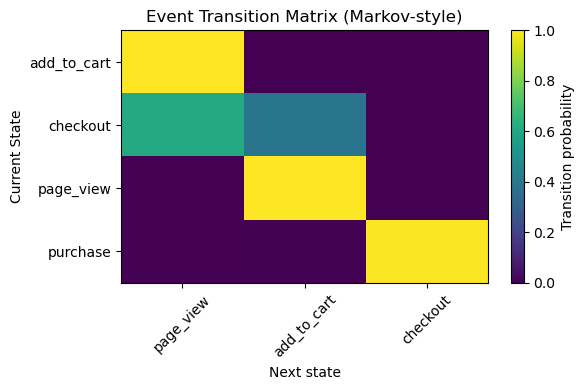

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.imshow(transition_probs, aspect="auto")
plt.colorbar(label="Transition probability")

plt.xticks(
        ticks=range(len(transition_probs.columns)),
        labels=transition_probs.columns,
        rotation=45
)
plt.yticks(
    ticks=range(len(transition_probs.index)),
    labels=transition_probs.index
)

plt.title("Event Transition Matrix (Markov-style)")
plt.xlabel("Next state")
plt.ylabel("Current State")
plt.tight_layout()
plt.show()

In [36]:
# Save for later analysis or SQL loading 
session_sequences.to_csv("../data/processed/session_paths.csv", index=False)
transition_counts.to_csv("../data/processed/event_transition_counts.csv")
transition_probs.to_csv("../data/processed/event_transition_probs.csv")

print("Saved:")
print(" ../data/processed/session_paths.csv")
print(" ../data/processed/event_transition_counts.csv")
print(" ../data/processed/event_transision_probs.csv")


Saved:
 ../data/processed/session_paths.csv
 ../data/processed/event_transition_counts.csv
 ../data/processed/event_transision_probs.csv


## 6. Summary 

- Reconstructed ordered event sequences per `session_id`
- Compressed them into clean state paths (e.g. `page_view -> add_to_cart -> checkout -> purchase`)
- Counted the most frequent navigation paths 
- Compared path distributios for purchasing vs non-purchasing sessions
- Built a Markov-style transition matrix between event types and visualised it as a heatmap

Outputs can be used for: 

- Funnel optimisation and UX improvements
- Journey prediction and churn/dropoff analysis
- Feeding into more advanced models (e.g. sequence-based CLV, reccomendations)